# Vision Transformers for Dense Prediction

Code: https://github.com/isl-org/DPT

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import types
import math
import numpy as np

from hubmap.models.dpt import DPT

In [15]:
model = DPT(num_classes=1)

## Try out DPT for an image

In [3]:
from hubmap.losses.bce_dice_loss import BCEDiceLoss
from torch.utils.data import DataLoader

import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns

### A quick check to see if the model is callable

In [6]:
from torchinfo import summary

In [51]:
model = DPT(num_classes=1, features=256, use_pretrained=True)

In [17]:
img = torch.rand(size=(3, 256, 256))
img = T.Normalize(mean=0.5, std=0.5)(img)
img = img.unsqueeze(0)

In [18]:
img.size()

torch.Size([1, 3, 256, 256])

In [19]:
model.eval()
with torch.no_grad():
    out = model(img)

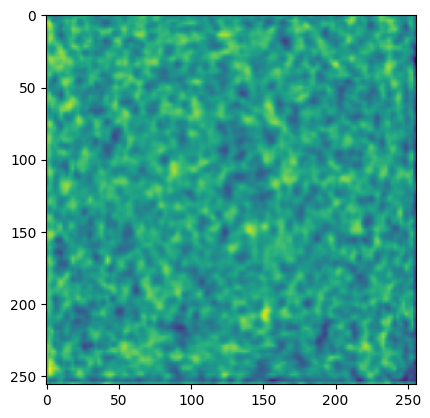

In [20]:
plt.imshow(out.squeeze())

In [50]:
summary(model, input_size=(4, 3, 128, 128))

Layer (type:depth-idx)                                                      Output Shape              Param #
DPT                                                                         [4, 1, 128, 128]          --
├─Module: 1-1                                                               --                        --
│    └─VisionTransformer: 2-1                                               --                        1,212,904
│    │    └─HybridEmbed: 3-1                                                --                        12,682,048
│    │    └─Dropout: 3-2                                                    [4, 65, 768]              --
│    │    └─Sequential: 3-3                                                 --                        85,054,464
│    │    └─LayerNorm: 3-4                                                  [4, 65, 768]              1,536
│    └─Sequential: 2-2                                                      --                        --
│    │    └─Identity: 3-

### Use dataset where we know how training works

In [21]:
import numpy as np
from PIL import Image
import einops
import torch
import torchvision.transforms as trf
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet


class CropResize:
    def __init__(self, img_size: int):
        self.resize = trf.Resize(
            (img_size, img_size), interpolation=trf.InterpolationMode.NEAREST
        )

    def __call__(self, img: Image.Image):
        min_size = np.min(img.size)
        crop = trf.functional.center_crop(img, min_size)
        resized = self.resize(crop)
        return resized


def map2onehot(segm_map: np.ndarray, n_classes: int = 3):
    assert segm_map.ndim == 2, "segm_map must have 2 dimensions"
    onehot = np.eye(n_classes)[segm_map]
    onehot = einops.rearrange(onehot, "h w c -> c h w")
    return onehot


def onehot2map(onehot: np.ndarray):
    assert onehot.ndim == 3, "onehot must have 3 dimensions"
    onehot = einops.rearrange(onehot, "c h w -> h w c")
    segm_map = np.argmax(onehot, axis=-1)
    return segm_map


class OxfordPetsDataset(OxfordIIITPet):
    def __init__(
        self,
        root: str = "./data",
        train: bool = True,
        download: bool = True,
        img_size: int = 64,
        segmentation_mode: str = "binary",
    ):
        """
        Wrapper for Oxford IIIT Pet dataset.

        Args:
            root: Folder where to store ds.
            train: If true, return training set, else test set.
            download: If true, download dataset.
            img_size: Output image size.
            segmentation_mode: Either 'binary' or 'trimap'. If 'binary', the segmentation map
                will have values 0 and 1, where 0 is the pet and 1 is the background. If 'trimap',
                the segmentation map will have values 0, 1 and 2, where 0 is the pet, 1 is
                the background and 2 is the border.
        """
        split = "trainval" if train else "test"
        super().__init__(
            root=root, split=split, download=download, target_types="segmentation"
        )

        self.crop_resize = CropResize(img_size)
        self.im_transform = trf.Compose([trf.ToTensor(), trf.Normalize(0.5, 0.5)])

        if segmentation_mode == "binary":
            self.binary_segmentation = True
        elif segmentation_mode == "trimap":
            self.binary_segmentation = False
        else:
            raise ValueError(
                f"Segmentation mode '{segmentation_mode}' not supported. "
                f"Choose between 'binary' and 'trimap'."
            )

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        """
        Returns:
            im: Tensor of shape (3, img_size, img_size).
            seg_map: Tensor of shape (1, img_size, img_size) if binary_segmentation is True,
                else one-hot encoded (3, img_size, img_size).
        """
        im, seg_map = super().__getitem__(idx)
        im = self.crop_resize(im)
        im = self.im_transform(im)

        seg_map = self.crop_resize(seg_map)
        seg_map = np.array(seg_map)
        seg_map = seg_map - 1  # convert to 0, 1, 2
        if self.binary_segmentation:
            seg_map[seg_map == 2] = 0  # make border belong to pet class
            seg_map = torch.tensor(seg_map, dtype=torch.float32)[None]  # (1, 64, 64)
        else:
            seg_map = map2onehot(seg_map, n_classes=3)  # (3, 64, 64)
            seg_map = torch.tensor(seg_map, dtype=torch.float32)

        return im, seg_map

### Now testing to train on a large dataset

In [22]:
H = W = 128

In [23]:
ts = T.Compose([
    T.Resize((H, W)),
    T.ToTensor(),
    T.Normalize(mean=0.5, std=0.5)  
])

In [24]:
target_transform = T.Compose([
    T.Resize((H, W)),
    T.ToTensor(),
])

In [25]:
td = OxfordPetsDataset(
    root="./data", train=True, download=True, segmentation_mode="trimap"
)
vd = OxfordPetsDataset(
    root="./data", train=False, download=True, segmentation_mode="trimap"
)

100%|█████████████████████████████████████████████████████████| 791918971/791918971 [00:19<00:00, 39859270.56it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|███████████████████████████████████████████████████████████| 19173078/19173078 [00:00<00:00, 32123732.91it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [26]:
def calculate_pixel_class(predicted_mask):
    probs = F.softmax(predicted_mask, dim=1)
    predicted_class = torch.argmax(probs, axis=1, keepdims=True)
    class_per_channel = torch.zeros(predicted_mask.size())
    class_per_channel[:, 0][predicted_class[:, 0] == 0] = 1
    class_per_channel[:, 1][predicted_class[:, 0] == 1] = 1
    class_per_channel[:, 2][predicted_class[:, 0] == 2] = 1
    return class_per_channel

In [27]:
def calculate_segmentation_accuracy(predicted_mask, ground_truth_mask, device):
    predicted_class = calculate_pixel_class(predicted_mask).to(device)
    equal = predicted_class == ground_truth_mask
    return torch.sum(equal) / torch.numel(equal)

In [28]:
BATCH_SIZE = 4

In [29]:
tl = DataLoader(td, batch_size=BATCH_SIZE, shuffle=True, num_workers=16)
vl = DataLoader(vd, batch_size=BATCH_SIZE, shuffle=False, num_workers=16)

In [30]:
model = DPT(num_classes=3, features=128)

In [31]:
# criterion = BCEDiceLoss()
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.BCEWithLogitsLoss()

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
model = model.to(device)

In [35]:
train_losses = train_accs = []
val_losses = val_accs = []

In [36]:
n_epochs = 5

In [37]:
import time

In [38]:
for epoch in range(n_epochs):
    epoch_start_time = time.time()
    train_start_time = time.time()
    train_batch_losses = train_batch_accs = []
    model.train()
    for images, targets in tl:
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        preds = model(images)

        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        
        acc = calculate_segmentation_accuracy(
            preds.detach(), targets.detach(), device
        )

        train_batch_losses.append(loss.item())
        train_batch_accs.append(acc.item())
    train_end_time = time.time()
    
    val_start_time = time.time()
    val_batch_losses = val_batch_accs = []
    model.eval()
    for images, targets in vl:
        images = images.to(device)
        targets = targets.to(device)
                
        with torch.no_grad():
            preds = model(images)
            loss = criterion(preds, targets)
            
            acc = calculate_segmentation_accuracy(
                preds.detach(), targets.detach(), device
            )
        
        val_batch_losses.append(loss.item())
        val_batch_accs.append(acc.item())
    val_end_time = time.time()
    
    train_losses.append(np.mean(train_batch_losses))
    train_accs.append(np.mean(train_batch_accs))
    val_losses.append(np.mean(val_batch_losses))
    val_accs.append(np.mean(val_batch_accs))
    
    epoch_end_time = time.time()
    
    train_timing = train_end_time - train_start_time
    train_timing = time.strftime("%H:%M:%S", time.gmtime(train_timing))

    val_timing = val_end_time - val_start_time
    val_timing = time.strftime("%H:%M:%S", time.gmtime(val_timing))
    
    epoch_timing = epoch_end_time - epoch_start_time
    epoch_timing = time.strftime("%H:%M:%S", time.gmtime(epoch_timing))

    print(
        f"Epoch ({epoch_timing}) {epoch+1}/{n_epochs} | "
        f"Train ({train_timing}): Loss = {np.mean(train_batch_losses):.6f} "
        f"- Accuracy = {(np.mean(train_batch_accs) * 100):.2f}% | "
        f"Val ({val_timing}): Loss = {np.mean(val_batch_losses):.6f} "
        f"- Accuracy = {(np.mean(val_batch_accs) * 100):.2f}%"
    )

Epoch (00:01:03) 1/5 | Train (00:00:49): Loss = 0.763578 - Accuracy = 76.36% | Val (00:00:14): Loss = 0.729052 - Accuracy = 72.91%
Epoch (00:01:06) 2/5 | Train (00:00:52): Loss = 0.719298 - Accuracy = 71.93% | Val (00:00:14): Loss = 0.712833 - Accuracy = 71.28%
Epoch (00:01:04) 3/5 | Train (00:00:50): Loss = 0.702272 - Accuracy = 70.23% | Val (00:00:14): Loss = 0.705126 - Accuracy = 70.51%
Epoch (00:01:05) 4/5 | Train (00:00:50): Loss = 0.686562 - Accuracy = 68.66% | Val (00:00:14): Loss = 0.703033 - Accuracy = 70.30%
Epoch (00:01:06) 5/5 | Train (00:00:51): Loss = 0.670392 - Accuracy = 67.04% | Val (00:00:14): Loss = 0.702242 - Accuracy = 70.22%


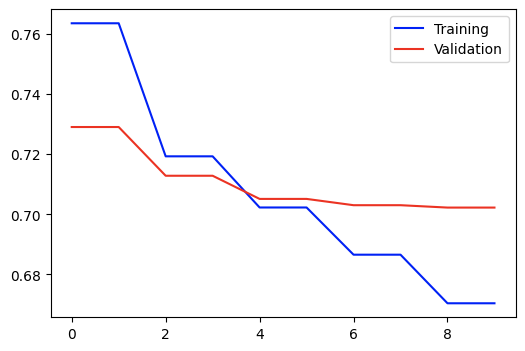

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.lineplot(
    x=[i for i in range(len(train_losses))],
    y=train_losses,
    color="#0021f5",
    ax=axs,
    label="Training",
)
sns.lineplot(
    x=[i for i in range(len(val_losses))],
    y=val_losses,
    color="#eb3323",
    ax=axs,
    label="Validation",
)
plt.legend(loc="upper right")
plt.show()

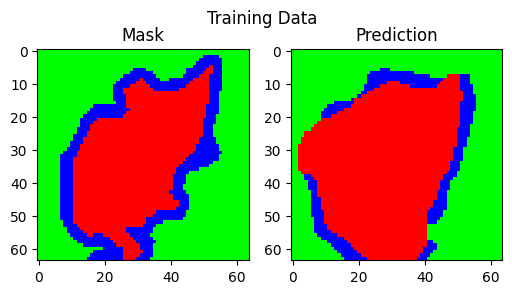

In [45]:
model.eval()
with torch.no_grad():
    out = model(td[0][0].unsqueeze(0).cuda())

predictions = calculate_pixel_class(out.detach().cpu())
prediction = predictions.squeeze().permute(1, 2, 0)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].imshow(td[0][1].permute(1, 2, 0))
axs[0].set_title("Mask")
axs[1].imshow(prediction)
axs[1].set_title("Prediction") 
_ = plt.suptitle("Training Data")

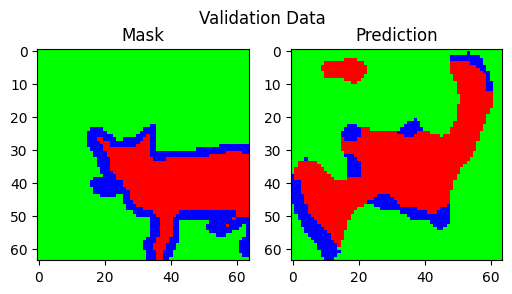

In [44]:
model.eval()
with torch.no_grad():
    out = model(vd[0][0].unsqueeze(0).cuda())

predictions = calculate_pixel_class(out.detach().cpu())
prediction = predictions.squeeze().permute(1, 2, 0)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].imshow(vd[0][1].permute(1, 2, 0))
axs[0].set_title("Mask")
axs[1].imshow(prediction)
axs[1].set_title("Prediction")
_ = plt.suptitle("Validation Data")